In [2]:
import hoomd

import hoomd.pair_plugin.pair as ppair

from monk import prep, pair

import ex_render

import numpy as np

In [3]:
N = 512
D = 3
phi_initial = 0.2
phi_final = 1.0
L = prep.len_from_phi(N, phi_initial, dim=D)
L_final = prep.len_from_phi(N, phi_final, dim=D)

In [5]:
device = hoomd.device.auto_select()
sim = hoomd.Simulation(device, seed=1234)

rng = prep.init_rng(123)
snap = prep.approx_euclidean_snapshot(N, L, rng, dim=D, particle_types=["A"], ratios=[100], diams=[1.0])
snap.particles.moment_inertia = N*[[1, 1, 1]]

sim.create_state_from_snapshot(snap)

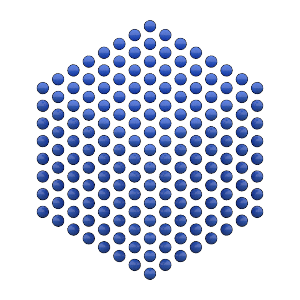

In [6]:
ex_render.render_sphere_frame(frame=sim.state.get_snapshot())

In [7]:
# thermalize the system

integrator = hoomd.md.Integrator(dt=0.0025, integrate_rotational_dof=False)
nvt = hoomd.md.methods.NVT(hoomd.filter.All(), 1.0, 0.25)
tree = hoomd.md.nlist.Tree(0.3)
# flj = ppair.FrictionLJ(tree, default_r_cut=2.5, mode="shift")
# flj.params[('A', 'A')] = dict(epsilon=1.0, aes=1.0, sigma=1.0, delta=0.0, mus=0.0, mur=np.inf, ks=0.0, kr=10.0)

flj = hoomd.md.pair.LJ(tree, default_r_cut=2.5)
flj.params[('A', 'A')] = dict(epsilon=1.0, sigma=1.0)


integrator.forces = [flj]
integrator.methods = [nvt]

sim.operations.integrator = integrator

In [8]:
sim.run(0)

nvt.thermalize_thermostat_dof()

sim.run(40_000)

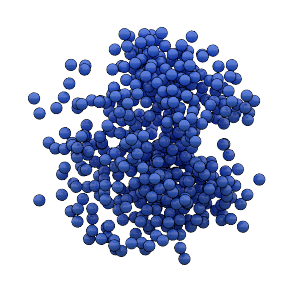

In [10]:
ex_render.render_sphere_frame(frame=sim.state.get_snapshot())

In [11]:
hoomd.write.GSD.write(sim.state, "friction_test_3d.gsd")

In [12]:
device = hoomd.device.auto_select()
sim = hoomd.Simulation(device, seed=1234)

sim.create_state_from_gsd("friction_test_3d.gsd")

In [13]:
# thermalize the system

integrator = hoomd.md.minimize.FIRE(
    dt=0.0025,
    force_tol=1e-2,
    angmom_tol=1e-2,
    energy_tol=1e-2,
    integrate_rotational_dof=True)
nvt = hoomd.md.methods.NPH(hoomd.filter.All(), 1.0, 1.0, couple="none", gamma=0.01)
tree = hoomd.md.nlist.Tree(0.2)
flj = ppair.FrictionLJ(tree, default_r_cut=2.5, mode="shift")
flj.params[('A', 'A')] = dict(epsilon=1.0, aes=0.0, sigma=1.0, delta=0.0, mus=0.5, mur=0.5, ks=10.0, kr=10.0)

integrator.forces = [flj]
integrator.methods = [nvt]

sim.operations.integrator = integrator

writer = hoomd.write.GSD(trigger=hoomd.trigger.Periodic(10), filename="test4.gsd", mode="wb", filter=hoomd.filter.All())
sim.operations.writers.clear()
sim.operations.writers.append(writer)

ramp = hoomd.variant.Ramp(0.0, 1.0, sim.timestep, 400)
fL = prep.len_from_phi(N, 0.8, dim=D)
initial_box = sim.state.box
final_box = hoomd.Box(Lx=L_final, Ly=L_final)
box_resize = hoomd.update.BoxResize(hoomd.trigger.Periodic(10), initial_box, final_box, ramp)

# sim.operations.updaters.append(box_resize)

sim.run(400)

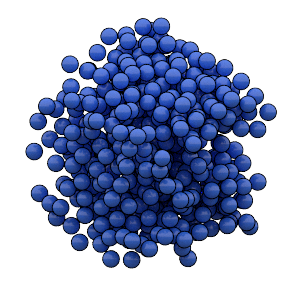

In [14]:
sim.run(8_000)
ex_render.render_sphere_frame(frame=sim.state.get_snapshot())

In [48]:
sim.state.get_snapshot().particles.position

array([[ 17.42263222,  25.15672112,   0.        ],
       [-13.52286243,  14.12936115,   0.        ],
       [-14.83320141,   6.51877165,   0.        ],
       ...,
       [  7.95228863,  23.35511017,   0.        ],
       [ -2.99411917,  -7.02119493,   0.        ],
       [-15.54184818, -25.26693535,   0.        ]])

In [15]:
from numba import njit

In [53]:
@njit
def pbc_distance_mag(coord1, cellsize):
    dist = np.expand_dims(coord1, 1) - np.expand_dims(coord1, 0)
    dist = dist - (np.rint(dist / cellsize)) * cellsize

    shape = dist.shape
    out = np.zeros(shape[:2])
    for i in range(shape[0]):
        for j in range(shape[1]):
            out[i, j] = np.linalg.norm(dist[i, j])
    return out

In [54]:
pbc_distance_mag(np.array([[0, 0, 0], [1, 1, 1]]), 2.0)

array([[0.        , 1.73205081],
       [1.73205081, 0.        ]])

In [35]:
arr = np.array([[0, 0, 0], [1, 1, 1]], dtype=np.float32)

In [42]:
np.expand_dims(arr, 1) - np.expand_dims(arr, 0)

array([[[ 0.,  0.,  0.],
        [-1., -1., -1.]],

       [[ 1.,  1.,  1.],
        [ 0.,  0.,  0.]]], dtype=float32)